# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Описание тарифов

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
    * сообщение: 3 рубля;
    * 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
    * минута разговора: 1 рубль;
    * сообщение: 1 рубль;
    * 1 Гб интернет-трафика: 150 рублей.

## Изучение общей информации о данных

Подключим библиотеки, необходимые в данном проекте

In [1]:
import pandas as pd #библиотека для работы с табличными типами данных
import math #библиотека для использования более продвинутых математических функций
import datetime as dt #библиотека для работы с типом данных datetime
import numpy as np #библиотека для использования формул из математической статистики
import matplotlib.pyplot as plt #библиотека для построения графиков

Создадим новые переменные: *calls, messages, internet, tariffs, users* и загрузим в них значения соответствующих файлов

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

data = [calls, messages, internet, tariffs, users]

Проверим, насколько корректно выгрузились данные

In [3]:
for table in data:
    display(table.head())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Таблицы выглядят корректно, однако в таблице *internet* замечен столбец, который не был описан, - *Unnamed: 0*. Его значения очень похожи на id, давайте рассмотрим поближе

In [4]:
display(internet['Unnamed: 0'].head(5), internet['Unnamed: 0'].tail(5),\
        'Максимальное количество уникальных значений:', internet['Unnamed: 0'].value_counts().max())

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64

149391    149391
149392    149392
149393    149393
149394    149394
149395    149395
Name: Unnamed: 0, dtype: int64

'Максимальное количество уникальных значений:'

1

Очень похоже на это. Скорее всего, id задвоился. Удалим данный столбец

In [5]:
internet = internet.drop('Unnamed: 0', 1)
internet.columns #проверка

Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

Также исправим название столбца *mb_per_month_included* на *mb_included*

In [6]:
tariffs = tariffs.rename(columns={'mb_per_month_included':'mb_included'})
tariffs.columns

Index(['messages_included', 'mb_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff_name'],
      dtype='object')

Теперь выведем общую информацию о каждой таблице

In [7]:
for table in data:
    display(table.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

In [8]:
users.isna().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

Как мы видим, пропуски в данных есть только в одной таблице в одном столбце *churn_date* (дата прекращения пользования тарифом). Если мы обратимся к описанию этого столбца, то узнаем следующее: "если значение пропущено, то тариф ещё действовал на момент выгрузки данных"

Вывод: мы получили первый взгляд на данные, по которому можно сказать следующее: случайных пропусков в данных не замечено; в некоторых местах данные необходимо привести к другим типам; обнаружен и удален столбец *Unnamed: 0* в таблице *internet* (скорее всего, столбец, в котором повторялись id)

## Подготовка данных

### Приведение к корректным типам данных

Первым делом приведем даты во всех таблицах к типу данных *datetime*

In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

#проверка
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Также поменяем тип данных в некоторых других столбцах

In [10]:
calls['duration'] = calls['duration'].apply(math.ceil).astype('uint16')
#округлили длительность звонков в большую сторону и привели к типу uint16 (максимальное значение - 65535)
users['age'] = users['age'].astype('uint8')
#привели возраст к типу данных uint8 (максимальное значение - 255)

#проверка
calls.info()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null uint16
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1), uint16(1)
memory usage: 5.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null uint8
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(1), object(4), uint8(1)
memory usage: 28.0+ KB


Мы изменили типы данных на более подходящие. Хотелось бы еще изменить тип данных у *user_id* во всех таблицах, но так как точной информации о максимальном количестве символом в данном столбце у нас нет, то и не будем там что-то менять

### Поиск дубликатов

Найдем дубликаты в каждой таблице

In [11]:
for table in data:
    display(table.duplicated().sum())

0

0

0

0

0

Дублирующиеся строчки не найдены

### Расчет дополнительных показателей

Найдем для каждого пользователя следующие значения:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя

Для того, чтобы искать информацию для каждого месяца, нам нужно извлечь информацию о месяце из данных с датой. Добавим таблицам *calls, messages* и *internet* колонки, в которых запишем месяц

In [12]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

display(calls.head(), messages.head(), internet.head())

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


Найдем количество сделанных звонков, потраченных минут, количество сообщений и объем использованного трафика по месяцам для каждого абонента

In [13]:
calls_by_months_by_users = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])\
.rename(columns={'count':'total_calls', 'sum':'minutes_used'})
calls_by_months_by_users.columns = calls_by_months_by_users.columns.droplevel(1)
calls_by_months_by_users.head()

total_calls  minutes_used
user_id month                           
1000    5               22           159
        6               43           172
        7               47           340
        8               52           408
        9               58           466

In [14]:
messages_by_months_by_users = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')\
.rename(columns={'id':'messages_used'})
messages_by_months_by_users.head()

messages_used
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57

In [15]:
internet_by_months_by_users = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_by_months_by_users.head()

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91

В таблицу с информацией об израсходованном трафике добавим еще один столбец *количество использованных гигабайт* (округлим по принципу округления компании)

In [16]:
#функция перевода количества использованных мегабайт в гигабайты с учетом округления в большую сторону
#1 гигабайт = 1024 мегабайта
def roundTraffic(traffic_mb):
    return math.ceil(traffic_mb / 1024)

In [17]:
internet_by_months_by_users['gb_used'] = internet_by_months_by_users['mb_used'].apply(roundTraffic).astype('int16')
internet_by_months_by_users.head()

mb_used  gb_used
user_id month                   
1000    5       2253.49        3
        6      23233.77       23
        7      14003.64       14
        8      14055.93       14
        9      14568.91       15

In [18]:
add_tables = [calls_by_months_by_users, messages_by_months_by_users, internet_by_months_by_users]
for table in add_tables:
    display(table.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
total_calls     3174 non-null int64
minutes_used    3174 non-null uint16
dtypes: int64(1), uint16(1)
memory usage: 44.3 KB


None

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2717 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
messages_used    2717 non-null int64
dtypes: int64(1)
memory usage: 32.7 KB


None

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3203 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
mb_used    3203 non-null float64
gb_used    3203 non-null int16
dtypes: float64(1), int16(1)
memory usage: 44.7 KB


None

Остается объединить расчитанные данные и найти выручку с каждого пользователя за каждый месяц

In [19]:
proceeds_by_months_by_users = calls_by_months_by_users.join([messages_by_months_by_users, internet_by_months_by_users],\
                                                            how='outer').reset_index() #убираем мультииндекс
display(proceeds_by_months_by_users.head(), proceeds_by_months_by_users.info())
#проверяем, не потерялись ли данныесравниваем с результатами .info() выше

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id          3214 non-null int64
month            3214 non-null int64
total_calls      3174 non-null float64
minutes_used     3174 non-null float64
messages_used    2717 non-null float64
mb_used          3203 non-null float64
gb_used          3203 non-null float64
dtypes: float64(5), int64(2)
memory usage: 175.9 KB


,user_id,month,total_calls,minutes_used,messages_used,mb_used,gb_used
0,1000,5,22.0,159.0,22.0,2253.49,3.0
1,1000,6,43.0,172.0,60.0,23233.77,23.0
2,1000,7,47.0,340.0,75.0,14003.64,14.0
3,1000,8,52.0,408.0,81.0,14055.93,14.0
4,1000,9,58.0,466.0,57.0,14568.91,15.0


None

В сводной таблице появились значения *NaN*. Это произошло из-за того, что за некоторые месяца у нас не было данных по тому или иному показателю (пример: абонент не отправлял смс-ки или не пользовался интернет-трафиком). Заменим все такие значения на нули

In [20]:
proceeds_by_months_by_users = proceeds_by_months_by_users.fillna(0)
proceeds_by_months_by_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id          3214 non-null int64
month            3214 non-null int64
total_calls      3214 non-null float64
minutes_used     3214 non-null float64
messages_used    3214 non-null float64
mb_used          3214 non-null float64
gb_used          3214 non-null float64
dtypes: float64(5), int64(2)
memory usage: 175.9 KB


Все *NaN* ушли. Теперь нужно узнать, какие у пользователей тарифы. Вытянем эту информацию из таблицы *users* и добавим к сводной таблице

In [21]:
proceeds_by_months_by_users = proceeds_by_months_by_users.merge(users[['user_id', 'tariff']], on='user_id')\
.rename(columns={'tariff':'tariff_name'})

In [22]:
display(proceeds_by_months_by_users.info(), proceeds_by_months_by_users.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id          3214 non-null int64
month            3214 non-null int64
total_calls      3214 non-null float64
minutes_used     3214 non-null float64
messages_used    3214 non-null float64
mb_used          3214 non-null float64
gb_used          3214 non-null float64
tariff_name      3214 non-null object
dtypes: float64(5), int64(2), object(1)
memory usage: 226.0+ KB


None

,user_id,month,total_calls,minutes_used,messages_used,mb_used,gb_used,tariff_name
0,1000,5,22.0,159.0,22.0,2253.49,3.0,ultra
1,1000,6,43.0,172.0,60.0,23233.77,23.0,ultra
2,1000,7,47.0,340.0,75.0,14003.64,14.0,ultra
3,1000,8,52.0,408.0,81.0,14055.93,14.0,ultra
4,1000,9,58.0,466.0,57.0,14568.91,15.0,ultra


In [23]:
proceeds_by_months_by_users = proceeds_by_months_by_users.merge(tariffs, on='tariff_name').sort_values(['user_id', 'month'])

In [24]:
proceeds_by_months_by_users.head()

,user_id,month,total_calls,minutes_used,messages_used,mb_used,gb_used,tariff_name,messages_included,mb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,2253.49,3.0,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23233.77,23.0,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14003.64,14.0,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14055.93,14.0,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,14568.91,15.0,ultra,1000,30720,3000,1950,150,1,1


Подсчитаем выручку с каждого клиента на основании потраченных ресурсов и подключенного тарифа.

Для начала добавим дополнительные столбцы с информацией о минутах, числе сообщений и гигабайт Интернета, использованных сверх предусмотренных тарифным планом

In [25]:
def extraMinutes(row):
    return row['minutes_used'] - row['minutes_included'] if row['minutes_used'] >= row['minutes_included'] else 0

def extraMessages(row):
    return row['messages_used'] - row['messages_included'] if row['messages_used'] >= row['messages_included'] else 0

def extraGb(row):
    return row['gb_used'] - row['mb_included'] / 1024 if row['gb_used'] >= row['mb_included'] / 1024 else 0

In [26]:
proceeds_by_months_by_users['extra_minutes'] = proceeds_by_months_by_users.apply(extraMinutes, axis=1)
proceeds_by_months_by_users['extra_messages'] = proceeds_by_months_by_users.apply(extraMessages, axis=1)
proceeds_by_months_by_users['extra_gb'] = proceeds_by_months_by_users.apply(extraGb, axis=1)
proceeds_by_months_by_users.sort_values('extra_minutes', ascending=False).head() #проверка

,user_id,month,total_calls,minutes_used,messages_used,mb_used,gb_used,tariff_name,messages_included,mb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_minutes,extra_messages,extra_gb
1988,1216,12,198.0,1435.0,64.0,20066.05,20.0,smart,50,15360,500,550,200,3,3,935.0,14.0,5.0
2991,1451,12,141.0,1144.0,50.0,16951.64,17.0,smart,50,15360,500,550,200,3,3,644.0,0.0,2.0
2177,1261,12,141.0,1074.0,22.0,32650.91,32.0,smart,50,15360,500,550,200,3,3,574.0,0.0,17.0
2060,1229,12,128.0,1022.0,6.0,24999.56,25.0,smart,50,15360,500,550,200,3,3,522.0,0.0,10.0
3157,1486,12,133.0,1007.0,83.0,38552.45,38.0,smart,50,15360,500,550,200,3,3,507.0,33.0,23.0


А теперь найдем, сколько заработал "Мегалайн" на каждом клиенте в тот или иной месяц

In [27]:
proceeds_by_months_by_users['extra_fee'] = \
proceeds_by_months_by_users['extra_minutes'] * proceeds_by_months_by_users['rub_per_minute'] \
+ proceeds_by_months_by_users['extra_messages'] * proceeds_by_months_by_users['rub_per_message'] \
+ proceeds_by_months_by_users['extra_gb'] * proceeds_by_months_by_users['rub_per_gb']
proceeds_by_months_by_users['total_fee'] = \
proceeds_by_months_by_users['rub_monthly_fee'] + proceeds_by_months_by_users['extra_fee']

proceeds_by_months_by_users.sort_values('extra_fee', ascending=False).head() #проверка

,user_id,month,total_calls,minutes_used,messages_used,mb_used,gb_used,tariff_name,messages_included,mb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_minutes,extra_messages,extra_gb,extra_fee,total_fee
3157,1486,12,133.0,1007.0,83.0,38552.45,38.0,smart,50,15360,500,550,200,3,3,507.0,33.0,23.0,6220.0,6770.0
1183,1042,12,121.0,728.0,75.0,37165.69,37.0,smart,50,15360,500,550,200,3,3,228.0,25.0,22.0,5159.0,5709.0
3156,1486,11,108.0,764.0,96.0,36266.11,36.0,smart,50,15360,500,550,200,3,3,264.0,46.0,21.0,5130.0,5680.0
2177,1261,12,141.0,1074.0,22.0,32650.91,32.0,smart,50,15360,500,550,200,3,3,574.0,0.0,17.0,5122.0,5672.0
2298,1286,12,95.0,739.0,68.0,35108.07,35.0,smart,50,15360,500,550,200,3,3,239.0,18.0,20.0,4771.0,5321.0


Вывод: мы проделали неплохую работу по сбору информации о пользователях, результатом которой стала сводная таблица, отражающая сколько пользователи используют ресурсы сверх тарифного плана и во сколько им это обходится. В самом затратном случае клиент потратил на экстра-минуты, -гигабайты и -смс более чем в 10 раз больше, чем на абонентскую плату. Такому абоненту стоит предложить перейти на более подходящий ему тариф *ultra*

## Анализ данных

Чтобы анализировать пользователей разных тарифов по отдельности, создадим две таблицы: с пользователями тарифа *smart* и *ultra*

In [28]:
smart_users_by_month = proceeds_by_months_by_users.query('tariff_name == "smart"')
ultra_users_by_month = proceeds_by_months_by_users.query('tariff_name == "ultra"')
display(smart_users_by_month.head(), ultra_users_by_month.head())

,user_id,month,total_calls,minutes_used,messages_used,mb_used,gb_used,tariff_name,messages_included,mb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_minutes,extra_messages,extra_gb,extra_fee,total_fee
985,1001,11,59.0,430.0,0.0,18429.34,18.0,smart,50,15360,500,550,200,3,3,0.0,0.0,3.0,600.0,1150.0
986,1001,12,63.0,414.0,0.0,14036.66,14.0,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0,0.0,550.0
987,1002,6,15.0,117.0,4.0,10856.82,11.0,smart,50,15360,500,550,200,3,3,0.0,0.0,0.0,0.0,550.0
988,1002,7,26.0,214.0,11.0,17580.10,18.0,smart,50,15360,500,550,200,3,3,0.0,0.0,3.0,600.0,1150.0
989,1002,8,42.0,289.0,13.0,20319.26,20.0,smart,50,15360,500,550,200,3,3,0.0,0.0,5.0,1000.0,1550.0


,user_id,month,total_calls,minutes_used,messages_used,mb_used,gb_used,tariff_name,messages_included,mb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,extra_minutes,extra_messages,extra_gb,extra_fee,total_fee
0,1000,5,22.0,159.0,22.0,2253.49,3.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
1,1000,6,43.0,172.0,60.0,23233.77,23.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
2,1000,7,47.0,340.0,75.0,14003.64,14.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
3,1000,8,52.0,408.0,81.0,14055.93,14.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0
4,1000,9,58.0,466.0,57.0,14568.91,15.0,ultra,1000,30720,3000,1950,150,1,1,0.0,0.0,0.0,0.0,1950.0


Рассмотрим, сколько в среднем за месяц расходуют минут, гигабайт и сообщений абоненты разных тарифных программ

In [29]:
display(smart_users_by_month[['minutes_used', 'messages_used', 'gb_used']].describe())
print('var(minutes_used) = {0:.2f}\nvar(messages_used) = {1:.2f}\nvar(gb_used) = {2:.2f}'.\
      format(np.var(smart_users_by_month['messages_used'], ddof=1), np.var(smart_users_by_month['minutes_used'], ddof=1),\
      np.var(smart_users_by_month['gb_used'], ddof=1)))

,minutes_used,messages_used,gb_used
count,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16.328847
std,190.313730,28.227876,5.747061
min,0.000000,0.000000,0.000000
25%,282.000000,10.000000,13.000000
50%,422.000000,28.000000,17.000000
75%,545.000000,51.000000,20.000000
max,1435.000000,143.000000,38.000000


var(minutes_used) = 796.81
var(messages_used) = 36219.32
var(gb_used) = 33.03


In [30]:
display(ultra_users_by_month[['minutes_used', 'messages_used', 'gb_used']].describe())
print('var(minutes_used) = {0:.2f}\nvar(messages_used) = {1:.2f}\nvar(gb_used) = {2:.2f}'.\
      format(np.var(ultra_users_by_month['messages_used'], ddof=1), np.var(ultra_users_by_month['minutes_used'], ddof=1),\
      np.var(ultra_users_by_month['gb_used'], ddof=1)))

,minutes_used,messages_used,gb_used
count,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.494416
std,317.606098,47.804457,9.853511
min,0.000000,0.000000,0.000000
25%,284.000000,6.000000,12.000000
50%,518.000000,38.000000,19.000000
75%,752.000000,79.000000,27.000000
max,1673.000000,224.000000,49.000000


var(minutes_used) = 2285.27
var(messages_used) = 100873.63
var(gb_used) = 97.09


Для наглядности выведем таблицу со средними значениями использованных минут, смс и Интернет-трафика в месяц для обоих тарифов и таблицу с предоставляемыми условиями тарифов

In [31]:
tariffs['gb_included'] = (tariffs['mb_included'] / 1024).astype('int8')
display('Условия по тарифам', tariffs[['minutes_included', 'messages_included', 'gb_included', 'tariff_name']])
min_mes_gb_mean_per_month_by_tariffs = pd.DataFrame({
    'minutes_used':[round(smart_users_by_month['minutes_used'].mean()), round(ultra_users_by_month['minutes_used'].mean())],
    'messages_used':[round(smart_users_by_month['messages_used'].mean()), round(ultra_users_by_month['messages_used'].mean())],
    'gb_used':[round(smart_users_by_month['gb_used'].mean()), round(ultra_users_by_month['gb_used'].mean())],
    'tariff_name':['smart', 'ultra']
})
display('Реальное использование', min_mes_gb_mean_per_month_by_tariffs)

'Условия по тарифам'

,minutes_included,messages_included,gb_included,tariff_name
0,500,50,15,smart
1,3000,1000,30,ultra


'Реальное использование'

,minutes_used,messages_used,gb_used,tariff_name
0,418,33,16,smart
1,527,49,19,ultra


Как мы видим, пользователи тарифа *smart* в среднем в месяц доплачивают за 1 гигабайт Интернета; остальных ресурсов им хватает.
Обладатели тарифного плана *ultra*, в основном, не доплачивают сверх абонентской платы, но зато используют ресурсы своего тарифа менее эффективно

Перейдем от цифр к графикам. Построим гистограммы по каждой из рассмотренных ранее величин для пользователей разных тарифов. Найдем закономерности

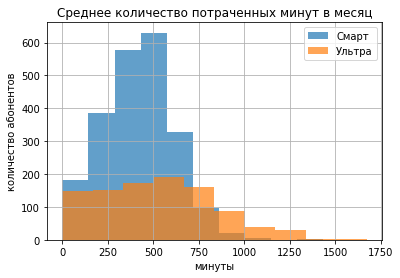

In [40]:
plt.hist(smart_users_by_month['minutes_used'], label='Смарт', alpha = 0.7)
plt.hist(ultra_users_by_month['minutes_used'], label='Ультра', alpha = 0.7)
plt.xlabel('минуты')
plt.ylabel('количество абонентов')
plt.title('Среднее количество потраченных минут в месяц')
plt.legend()
plt.grid()
plt.show()

Оба набора данных скошены влево. Это говорит нам о том, что большинству пользователей хватает 500-600 минут звонков в месяц. Но бывают и выбросы (более 1000 минут)

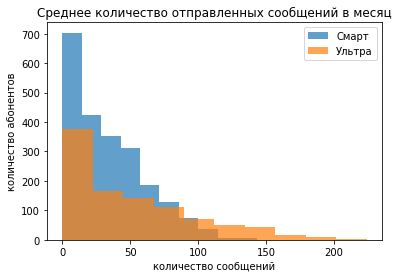

In [33]:
plt.hist(smart_users_by_month['messages_used'], label='Смарт', alpha = 0.7)
plt.hist(ultra_users_by_month['messages_used'], label='Ультра', alpha = 0.7)
plt.xlabel('количество сообщений')
plt.ylabel('количество абонентов')
plt.title('Среднее количество отправленных сообщений в месяц')
plt.legend()
plt.grid()
plt.show()

Наборы данных о сообщениях скошены вправо, причем очень серьезно. По гистограммам видно, что сообщения изживают себя и уходят в прошлое. Большинству пользователей хватает и 50 сообщений в месяц; самым требовательным необходимо до 80; больше 80 - единицам

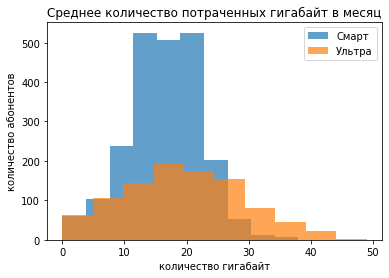

In [34]:
plt.hist(smart_users_by_month['gb_used'], label='Смарт', alpha = 0.7)
plt.hist(ultra_users_by_month['gb_used'], label='Ультра', alpha = 0.7)
plt.xlabel('количество гигабайт')
plt.ylabel('количество абонентов')
plt.title('Среднее количество потраченных гигабайт в месяц')
plt.legend()
plt.grid()
plt.show()

Самые симметричные графики получились у наборов распределения Интернет-трафика. Глядя на них, можно сказать, что с предлагаемым количеством мобильного Интернета компания в своих тарифах угадала больше всего (точнее всего попала в потребность пользователей)

Вывод: проанализировав средние значения по потраченным минутам, гигабайтам и сообщениям, мы пришли к выводу о том, что пользователи зачастую расходуют меньше, чем предусмотрено тарифным планом. Единственным моментом, где абоненты чаще тратятся на приобретение пакетов доп. услуг, является недостаток количества Интернет-трафика в тарифе *Smart*. В среднем пользователи данного тарифа докупают 1 гигабайт мобильного Интернета в месяц

## Проверка гипотез

Проверим на наших данных некоторые гипотезы:
* средняя выручка на одного пользователя тарифов «Ультра» и «Смарт» различаются;
* средняя выручка на одного пользователя из Москвы отличается от выручки пользователей из других регионов.

Для проверки гипотез будем использовать Т-критерий Стьюдента для независимых выборок

Пойдем по порядку, начнем с первой гипотезы. Для начала найдем средние значения и дисперсии данных выборок, сравним "на глазок"

In [35]:
print('Средняя выручка на одного пользователя тарифа smart: {0:.2f}\nДисперсия: {1:.2f}'.\
        format(smart_users_by_month['total_fee'].mean(), np.var(smart_users_by_month['total_fee'], ddof=1)))
print('\nСредняя выручка на одного пользователя тарифа ultra: {0:.2f}\nДисперсия: {1:.2f}'.\
        format(ultra_users_by_month['total_fee'].mean(), np.var(ultra_users_by_month['total_fee'], ddof=1)))

Средняя выручка на одного пользователя тарифа smart: 1289.97
Дисперсия: 669785.71

Средняя выручка на одного пользователя тарифа ultra: 2070.15
Дисперсия: 141516.75


Как мы видим, выборки не очень похожи друг на друга: пользователи тарифа *Smart* в среднем тратят меньше, но разброс в выручке по таким пользователям сильно выше, чем по пользователям тарифа *Ultra*. Для большей наглядности построим гистограммы распределений

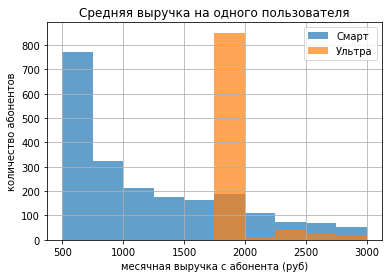

In [41]:
plt.hist(smart_users_by_month['total_fee'], label='Смарт', alpha = 0.7, range=(500, 3000))
plt.hist(ultra_users_by_month['total_fee'], label='Ультра', alpha = 0.7, range=(500, 3000))
plt.xlabel('месячная выручка с абонента (руб)')
plt.ylabel('количество абонентов')
plt.title('Средняя выручка на одного пользователя')
plt.legend()
plt.grid()
plt.show()

Пользователи тарифа *Смарт* тратят в среднем меньше, но гораздо чаще приобретают пакеты допольнительных услуг. Но пока все наши выводы были сделаны на основе нашего первого взгляда на данные выборки. Теперь же обратимся к инструментам статистического анализа, чтобы узнать вероятность равенства средних значений при подобных выборках

Сформируем нулевую гипотезу: средняя выручка на одного пользователя тарифа *Смарт* равна средней выручке на одного пользователя тарифа *Ультра* - и проверим ее с помощью Т-теста для двух независимых совокупностей. Критический уровень статистической значимости установим 0.05, так как большая точность нам неважна

In [37]:
from scipy import stats as st #библиотека для использования статистических методов

results = st.ttest_ind(smart_users_by_month['total_fee'], ultra_users_by_month['total_fee'], equal_var=False)
alpha = 0.05

print('p-value = {0:.2e}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value = 4.26e-250
Отвергаем нулевую гипотезу


Результаты данного теста говорят нам о том, что вероятность получить одинаковые средние значения между данными совокупностями крайне мала (4.26е-250)

Проделаем такую же проверку с помощью Т-теста для независимых совокупностей для гипотезы о равенстве средних выручек из Москвы и регионов.

Сформулируем нулевую гипотезу: средняя выручка на одного пользователя из Москвы равна средней выручке на одного пользователя не из Москвы.

Критический уровень значимости возьмем такой же

In [38]:
proceeds_by_months_by_users = proceeds_by_months_by_users.merge(users[['user_id', 'city']], on='user_id')

In [39]:
results = st.ttest_ind(proceeds_by_months_by_users.query('city == "Москва"')['total_fee'],\
                       proceeds_by_months_by_users.query('city != "Москва"')['total_fee'], equal_var=False)

print('p-value = {0:.2f}'.format(results.pvalue))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value = 0.53
Не получилось отвергнуть нулевую гипотезу


Вероятность того, что другие случайные выборки из совокупности пользователей из Москвы и не из Москвы в среднем будут равны, составляет 53%, что существенно выше, чем выбранный критический уровень значимости (5%). Соответственно, данную гипотезу мы отвергнуть не можем

Вывод: мы проверили две гипотезы по выборкам данных. Вероятность того, что пользователи разных тарифов тратят в месяц одинаковую сумму денег крайне оказалась крайне низкой, поэтому гипотезу о равной выручке на пользователей разных тарифных планов пришлось отвергнуть. Гипотезу о том, что пользователи из Москвы и регионов тратят одинаковое количество денег на услуги мобильной связи, отвергнуть не удалось, так как вероятность такого исхода 0.53, что выше выбранного нами критического уровня значимости

## Вывод

Мы провели косметическую предобработку данных: удалили лишний столбец, дублирующий *id* в таблице *internet*, также сделали преобразование типов данных в некоторых местах.

После анализа используемых ресурсов мы пришли к тому, что количество сообщений, включенных в тарифные планы и звонков, в основном, пользователям хватает, тогда как Интернет абоненты тарифа *Смарт* зачастую докупают в течение месяца, таким пользователям стоит предложить перейти на тариф *Ультра*, либо ввести дополнительный (промежуточный) вариант тарифа, который удовлетворил бы их потребности

Также для данной выборки пользователей мы проверили ряд гипотез:
* средняя выручка для абонентов тарифа *Смарт* равна средней выручке для абонента тарифа *Ультра* - нулевая гипотеза отвергнута; p-value = 4.26e-250
* средняя выручка для пользователей из Москвы равна средней выручке для пользователей из регионов - нулевая гипотеза не отвергнута; p-value = 0.53